In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

In [2]:
sc = SparkContext()
sqlContext = SQLContext(sc)

In [3]:
df = sqlContext.read.csv('d_small_ecommerce-data.csv', header=True)

In [4]:
#df.show()

In [5]:
import datetime as dt
from pyspark.sql.functions import *

now = to_date(lit(dt.date(2011,12,9)))

df = df.withColumn('Date', to_date(df['InvoiceDate']))

recency_df = df.groupby('CustomerID').agg(max('Date').alias('LastPurchaseDate'))
recency_df = recency_df.withColumn("Recency", datediff(now, to_date(recency_df['LastPurchaseDate'])))
recency_df = recency_df.select(['CustomerID', 'Recency'])
#recency_df.show()

In [6]:
frequency_df = df.drop_duplicates(['CustomerID', 'InvoiceNo'])
frequency_df = frequency_df.groupby('CustomerID').agg(count('InvoiceNo').alias('Frequency'))
#frequency_df.show()

In [7]:
df = df.withColumn("Quantity", df["Quantity"].cast('int'))
df = df.withColumn("UnitPrice", df["UnitPrice"].cast('float'))

df = df.filter((df['Quantity'] > 0) & (df['UnitPrice'] > 0) & (df['UnitPrice'] < 15))

df = df.withColumn('TotalPrice', df['Quantity'] * df['UnitPrice'])
df = df.filter(df['TotalPrice'] < 25000)

monetary_df = df.groupby('CustomerID').agg(sum('TotalPrice').alias('Monetary'))
#monetary_df.show()

In [8]:
rfm = recency_df.join(frequency_df, on=['CustomerID'], how='inner')
rfm = rfm.join(monetary_df, on=['CustomerID'], how='inner')
rfm.show()

+----------+-------+---------+------------------+
|CustomerID|Recency|Frequency|          Monetary|
+----------+-------+---------+------------------+
|   17850.0|    373|        1| 98.31999969482422|
|   16270.0|    353|        1|100.05999946594238|
|   17211.0|    353|        1| 54.09000015258789|
|   12680.0|      0|        1| 141.4500026702881|
|   12678.0|    353|        1| 53.28000259399414|
+----------+-------+---------+------------------+



In [9]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=['Recency', 'Frequency', 'Monetary'],
    outputCol="features")

rfm = rfm.withColumnRenamed('CustomerID', 'id')

rfm_final = assembler.transform(rfm).select('id', 'features')
rfm_final.show()

+-------+--------------------+
|     id|            features|
+-------+--------------------+
|17850.0|[373.0,1.0,98.319...|
|16270.0|[353.0,1.0,100.05...|
|17211.0|[353.0,1.0,54.090...|
|12680.0|[0.0,1.0,141.4500...|
|12678.0|[353.0,1.0,53.280...|
+-------+--------------------+



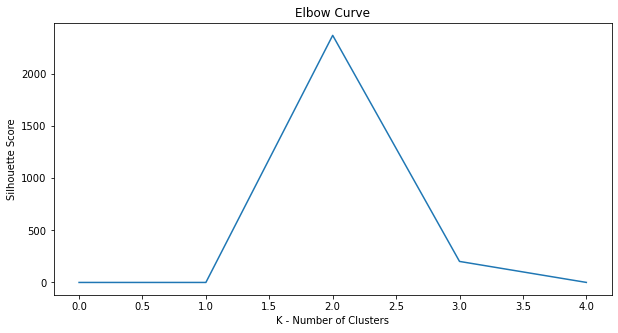

In [10]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

n_clusters = 5
cost = np.zeros(n_clusters)
silh_val = []
silh_lst = []

for k in range(2, n_clusters):
    kmeans = KMeans().setK(k).setSeed(1).setFeaturesCol("features")
    model = kmeans.fit(rfm_final)# rfm_final.sample(False,0.1, seed=42)
    cost[k] = model.summary.trainingCost
    
    predictions = model.transform(rfm_final)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    silh_val.append(silhouette)

df_cost = pd.DataFrame(cost)
df_cost.columns = ['cost']
k_lst = np.arange(n_clusters)
df_cost.insert(0, 'cluster', k_lst)

silh_array = np.asanyarray(silh_val)
silhouette = pd.DataFrame(list(zip(k_lst[2:],silh_array)),columns = ['k clusters', 'silhouette'])

plt.figure(figsize=(10,5))
plt.plot(df_cost.cluster, df_cost.cost)
plt.xlabel('K - Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Elbow Curve')

plt.show()

In [11]:
silhouette

,k clusters,silhouette
0,2,0.790485
1,3,0.728716
2,4,0.399878


In [12]:
"""
kmeans = KMeans().setK(2).setSeed(1).setFeaturesCol("features")
model = kmeans.fit(rfm_final)

predictions = model.transform(rfm_final)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)
"""

'\nkmeans = KMeans().setK(2).setSeed(1).setFeaturesCol("features")\nmodel = kmeans.fit(rfm_final)\n\npredictions = model.transform(rfm_final)\n\n# Evaluate clustering by computing Silhouette score\nevaluator = ClusteringEvaluator()\n\nsilhouette = evaluator.evaluate(predictions)\nprint("Silhouette with squared euclidean distance = " + str(silhouette))\n\ncenters = model.clusterCenters()\nprint("Cluster Centers: ")\nfor center in centers:\n    print(center)\n'

In [13]:
predictions = predictions.withColumnRenamed('id', 'CustomerID')
predictions = predictions.withColumnRenamed('prediction', 'Cluster')
predictions = predictions.select(['CustomerID', 'Cluster'])
predictions.show()

+----------+-------+
|CustomerID|Cluster|
+----------+-------+
|   17850.0|      2|
|   16270.0|      3|
|   17211.0|      0|
|   12680.0|      1|
|   12678.0|      0|
+----------+-------+



In [14]:
predictions.write.csv('customer_segmentation.csv')